# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
_ = sum(data[data.race=='b'].call)
print(f'Number of callbacks for black-sounding names is {_}')
display(data.head())
display(data.columns)

Number of callbacks for black-sounding names is 157.0


,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


Index(['id', 'ad', 'education', 'ofjobs', 'yearsexp', 'honors', 'volunteer',
       'military', 'empholes', 'occupspecific', 'occupbroad', 'workinschool',
       'email', 'computerskills', 'specialskills', 'firstname', 'sex', 'race',
       'h', 'l', 'call', 'city', 'kind', 'adid', 'fracblack', 'fracwhite',
       'lmedhhinc', 'fracdropout', 'fraccolp', 'linc', 'col', 'expminreq',
       'schoolreq', 'eoe', 'parent_sales', 'parent_emp', 'branch_sales',
       'branch_emp', 'fed', 'fracblack_empzip', 'fracwhite_empzip',
       'lmedhhinc_empzip', 'fracdropout_empzip', 'fraccolp_empzip',
       'linc_empzip', 'manager', 'supervisor', 'secretary', 'offsupport',
       'salesrep', 'retailsales', 'req', 'expreq', 'comreq', 'educreq',
       'compreq', 'orgreq', 'manuf', 'transcom', 'bankreal', 'trade',
       'busservice', 'othservice', 'missind', 'ownership'],
      dtype='object')

<div class="span5 alert alert-success">
<p>Your answers to Q1 and Q2 here</p>
</div>

# What test is appropriate? Does CLT apply?

### z-test (or) bootstrap test would be appropriate.

Lets define two statistics: 
1. Mu-b, Fraction of the African-American candidates who are invited for job interviews
2. Mu-w, Fraction of the European-American candidates who are invited for job interviews.

The question is, are Mu-b and Mu-W same?

The following 3 conditions are to be satisfied before one can perform inference on these mean:

1. Random sample (or) randomized experiment should be used.
2. Mean of the sample needs to be approximately normal. This is true if the parent population is normal or if the sample is reasonably large (n>= 30).
The sample size is 2435, well above 30. 
3. Individual observa"ons need to be independent. If sampling without replacement, our sample size shouldn't be more than 10% of the population.
The population of African & European Americans is well above millions. The sample size selected here is well below the 10% threshold.


In [4]:
def make_histogram(data, x_label, y_label, fig_no, kde_var=False, **kwargs):
    plt.figure(fig_no, figsize=(8,5))
    #no_of_bins = int(len(data)**0.5) # Calculate bins sqrt(len(data))
    no_of_bins = 30
    x = sns.distplot(data, hist=True, kde=kde_var, rug=False)
    _ = plt.xlabel(x_label)
    _ = plt.ylabel(y_label)
    if 'xlimits' in kwargs:
        _ = plt.xlim(kwargs['xlimits'])
    else:
        plt.margins(0.02)
    
    if 'title' in kwargs:
        _ = plt.title(kwargs['title'], fontsize=16)
    
    plt.axvline(np.mean(data), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(np.median(data), color='r', linestyle='dashed', linewidth=1)
    
     
    ymin, ymax = plt.ylim()
    xmin, xmax = plt.xlim()
    yrange = ymax - ymin
    xrange = xmax - xmin
    mean_string = "Mean (black line) is {}".format(round(np.mean(data),2))
    median_string = "Median (red line) is {}".format(round(np.median(data),2))
    std_string = "Std. Dev is {}".format(round(np.std(data),2))
    plt.annotate(mean_string, xy = (np.mean(data), ymax), xytext = (xmin+xrange*0.7, ymin+yrange*0.7))
    plt.annotate(median_string, xy = (np.median(data), ymax), xytext = (xmin+xrange*0.7, ymin+yrange*0.6))
    plt.annotate(std_string, xy = (np.median(data), ymax), xytext = (xmin+xrange*0.7, ymin+yrange*0.5))
    
    if 'obs_statistic' in kwargs:
        plt.axvline(kwargs['obs_statistic'], color='b', linestyle='dashed', linewidth=1)
        plt.axvline(0-kwargs['obs_statistic'], color='b', linestyle='dashed', linewidth=1)
        plt.annotate('Observed Statistic in Blue Line', xy = (np.median(data), ymax), 
                     xytext = (xmin+xrange*0.1, ymin+yrange*0.5))
   
    plt.show()

In [5]:
w = data[data.race=='w']
b = data[data.race=='b']
print(f'# of white samples is {w.shape[0]}')
print(f'# of black samples is {b.shape[0]}')

# of white samples is 2435
# of black samples is 2435


# What are the null and alternate hypotheses?

Lets define three statistics: 
1. mu_b, Fraction of the African-American candidates who are invited for job interviews
2. mu_w, Fraction of the European-American candidates who are invited for job interviews.
3. mu_diff = mu_w - mu_b, Difference in the fraction of calls recieved by European & African Americans. 

Null Hypothesis: mu_diff = 0 <br/>
Alternative Hypothesis: mu_diff > 0

# Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

## Frequentist Statistical Approach

Where a candidate will be called for interview or not is a binomial random variable based on:

1. Independent trials
2. Each trial can only result in being called (1) or not (0).
3. Fixed number of trials.
4. Probability of success is constant.

In [6]:
alpha = 0.01


def frac_diff(data):
    w = data[data.race=='w']
    b = data[data.race=='b']
    fraction_calls_b = sum(b.call)/b.shape[0]
    fraction_calls_w = sum(w.call)/w.shape[0]
    std_fraction_calls_b = ( fraction_calls_b*(1-fraction_calls_b)/b.shape[0] )**0.5 # Std of population mean
    std_fraction_calls_w = ( fraction_calls_w*(1-fraction_calls_w)/w.shape[0] )**0.5
    #print(f'1. For African Americans, Mean call fraction is {round(fraction_calls_b,3)} and std.dev of {round(std_fraction_calls_b,4)}')
    #print(f'2. For European Americans, Mean call fraction is {round(fraction_calls_w,3)} and std.dev of {round(std_fraction_calls_w,4)}')
    #print('======================')
    fraction_diff = fraction_calls_w - fraction_calls_b
    std_fraction_diff = (std_fraction_calls_b**2 + std_fraction_calls_w**2)**0.5
    frac_results = (fraction_diff, std_fraction_diff)
    return frac_results

diff_frac_obs, std_diff_frac = frac_diff(data)
diff_frac_exp = 0
z_score = (diff_frac_obs - diff_frac_exp)/std_diff_frac
p_value = 1 - stats.norm.cdf(z_score)

print(f'3. p-value = {round(p_value,5)*100}%')
print(f'4. alpha (or) Margin of error = {alpha * 100}%')
print(f'5. 99% conf interval for diff in the mean call rate of European & African Americans is {round(diff_frac_obs,4)} +/- {round(2.57*std_diff_frac, 4)}')
#print(f'{round(fraction_diff_obs,4)} +/- {round(2.57*std_fraction_diff, 4)}')

if (p_value < alpha):
    print(f'6. p-value= {round(p_value,5)*100}% is < Alpha {alpha*100}%, Reject Null Hypothesis'
          ': Call rate of European Americans is equal to that of African Americans')
else:
    print(f'6. p-value= {round(p_value,5)*100}% is <= Alpha {alpha*100}, Do not reject Null Hypothesis'
          ': Call rate of European Americans is equal to that of African Americans')

3. p-value = 0.002%
4. alpha (or) Margin of error = 1.0%
5. 99% conf interval for diff in the mean call rate of European & African Americans is 0.032 +/- 0.02
6. p-value= 0.002% is < Alpha 1.0%, Reject Null Hypothesis: Call rate of European Americans is equal to that of African Americans


## Using Bootstrap Approach

In [7]:
no_of_simulations = 10000
diff_frac_runs = np.empty(no_of_simulations)
for i in range(no_of_simulations):
    race_temp = np.random.choice(data['race'], len(data['race']))
    call_temp = np.random.choice(data['call'], len(data['call']))
    df_temp = pd.DataFrame({'race':race_temp, 'call':call_temp})
    _, diff_frac_runs[i]=frac_diff(df_temp)

p_value = np.sum(diff_frac_runs>diff_frac_obs)/no_of_simulations
print(p_value)
if (p_value < alpha):
    print(f'6. p-value= {round(p_value,5)*100}% is < Alpha {alpha*100}%, Reject Null Hypothesis'
          ': Call rate of European Americans is equal to that of African Americans')
else:
    print(f'6. p-value= {round(p_value,5)*100}% is <= Alpha {alpha*100}, Do not reject Null Hypothesis'
          ': Call rate of European Americans is equal to that of African Americans')

0.0
6. p-value= 0.0% is < Alpha 1.0%, Reject Null Hypothesis: Call rate of European Americans is equal to that of African Americans


/Users/Murali/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


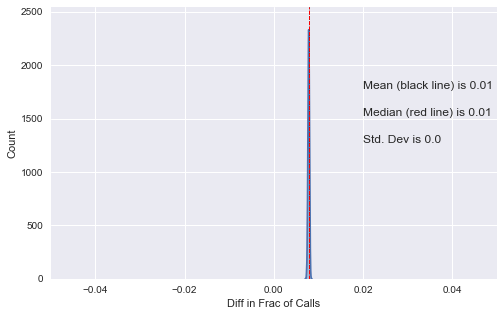

In [8]:
make_histogram(diff_frac_runs, 'Diff in Frac of Calls', 'Count', 1, kde_var=True, xlimits=[-0.05, 0.05])

<div class="span5 alert alert-success">
<p> Your answers to Q4 and Q5 here </p>
</div>

# 4. Write a story describing the statistical significance in the context or the original problem.

Statistical significance in this analysis refers to the p-value.
The call rate for black sounding names was 6.4% and those for white sounding names was 9.7%. The question: is the difference of 3.2% explainable by random chance?
The p-value came out to be 0.002% (frequentist approach) and 0% (bootstrap approach). This means that the probability of getting the observed call rate of 3.2% purely by chance is 0% or close to it.

# 5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

Chance alone cannot describe the higher call rate for white sounding names when compared to black sounding names. This does not mean that race (or) name is the most important factor. There are 63 other variables. One has to look if any of them can explain this variation. Perhaps a regression analysis needs to be performed to study the impact of other variables.

In [12]:
print(data.shape)

(4870, 65)
